In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 35.3 MB/s eta 0:00:00


In [ ]:
wandb.login()

True

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets

In [ ]:
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [ ]:
# we will use these later for the CNN
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [ ]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            # transforms.Resize(size=resolution, antialias=True),
            # transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p = 0.25),
            transforms.RandomPerspective(distortion_scale=0.6, p=0.25),
            transforms.RandomGrayscale(p=0.5),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [ ]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

In [ ]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

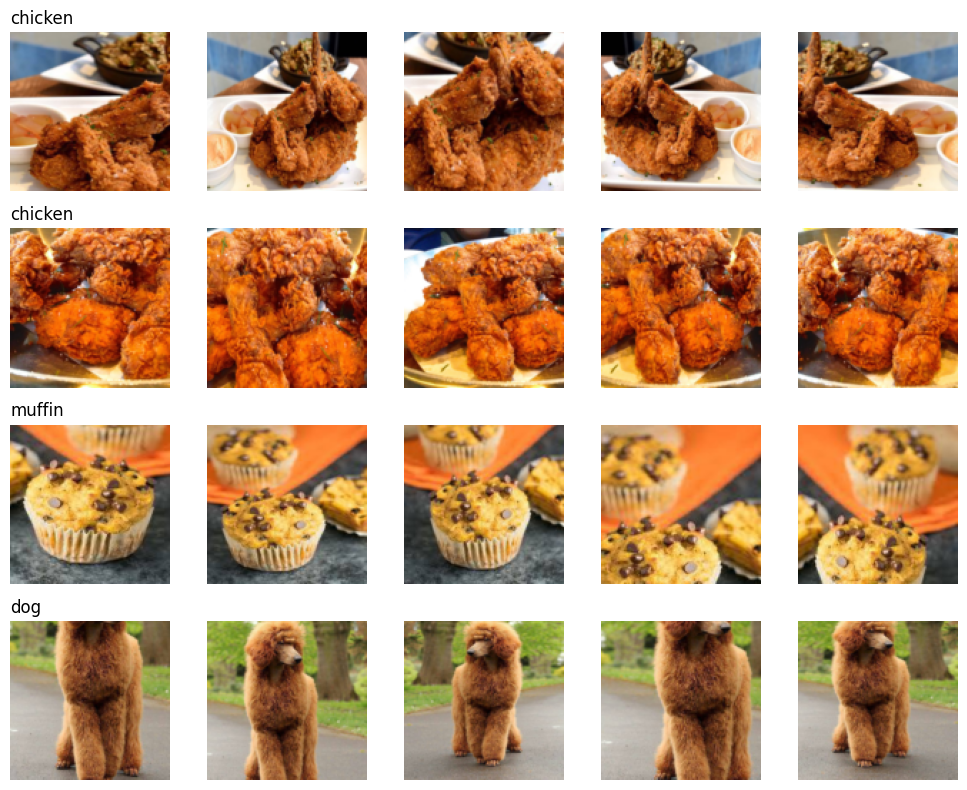

In [ ]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

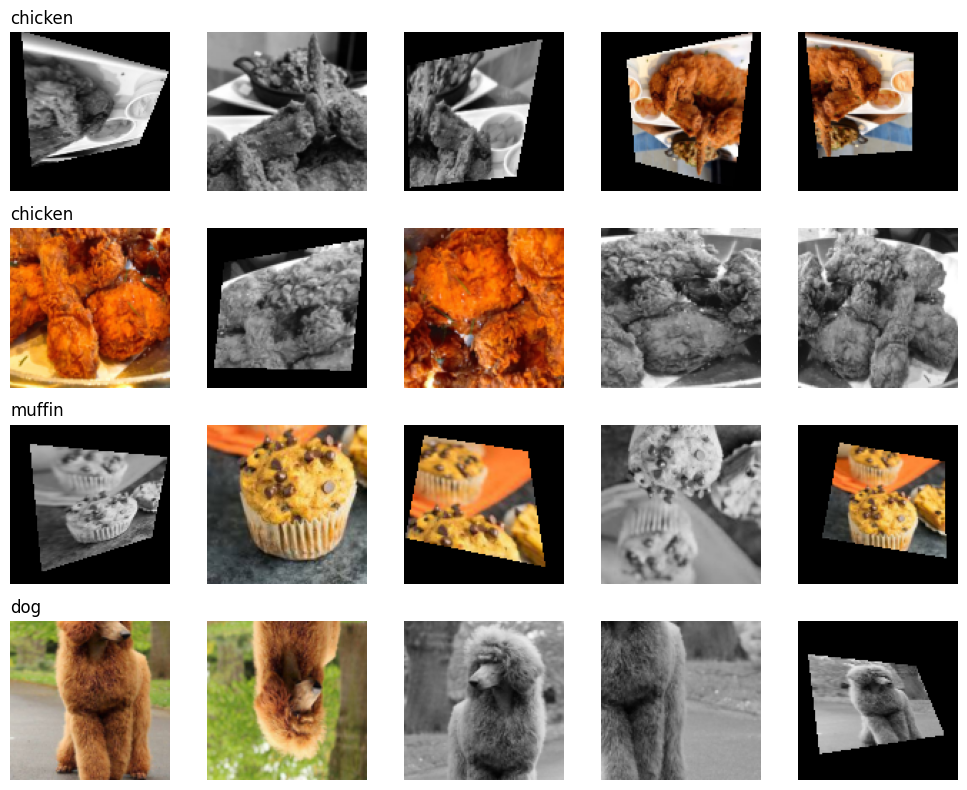

In [ ]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

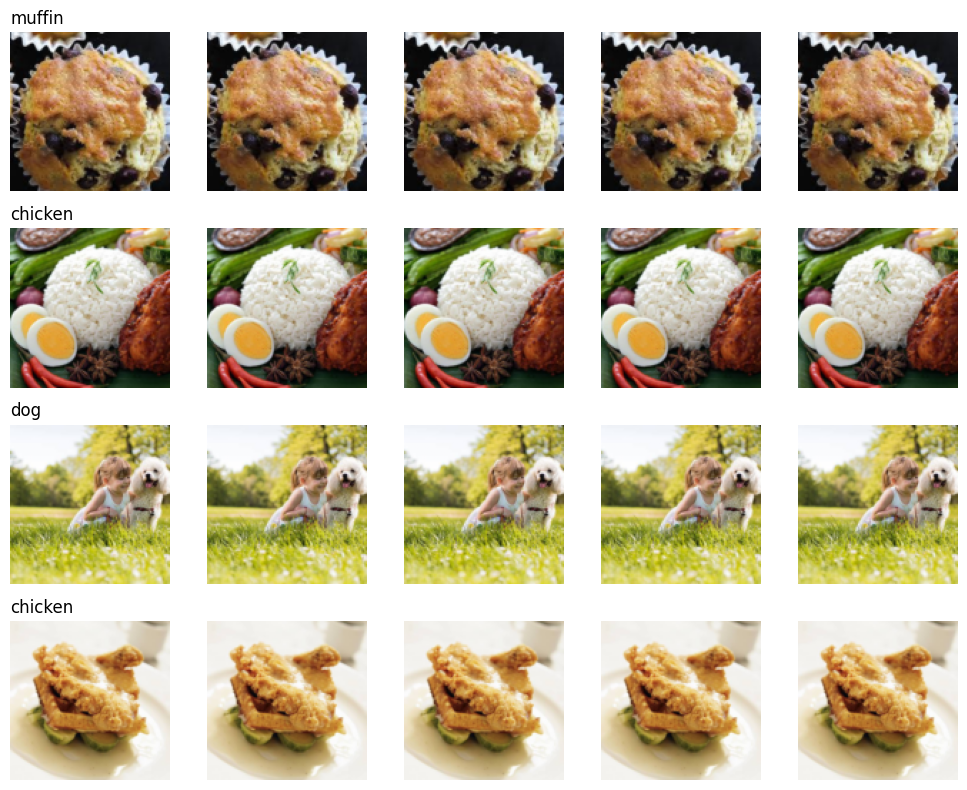

In [ ]:
#visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix


class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])
        self.confusion_matrix.update(pred_labels, batch["label"])
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)
        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)
total_params = sum(p.numel() for p in model.parameters())
print("Total params: ", total_params)

Total params:  112771


In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

total_params = sum(p.numel() for p in model.parameters())
print("Total params: ", total_params)
# model = torchvision.models.mobilenet_v2(num_classes=num_classes)

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Total params:  113283
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


In [ ]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

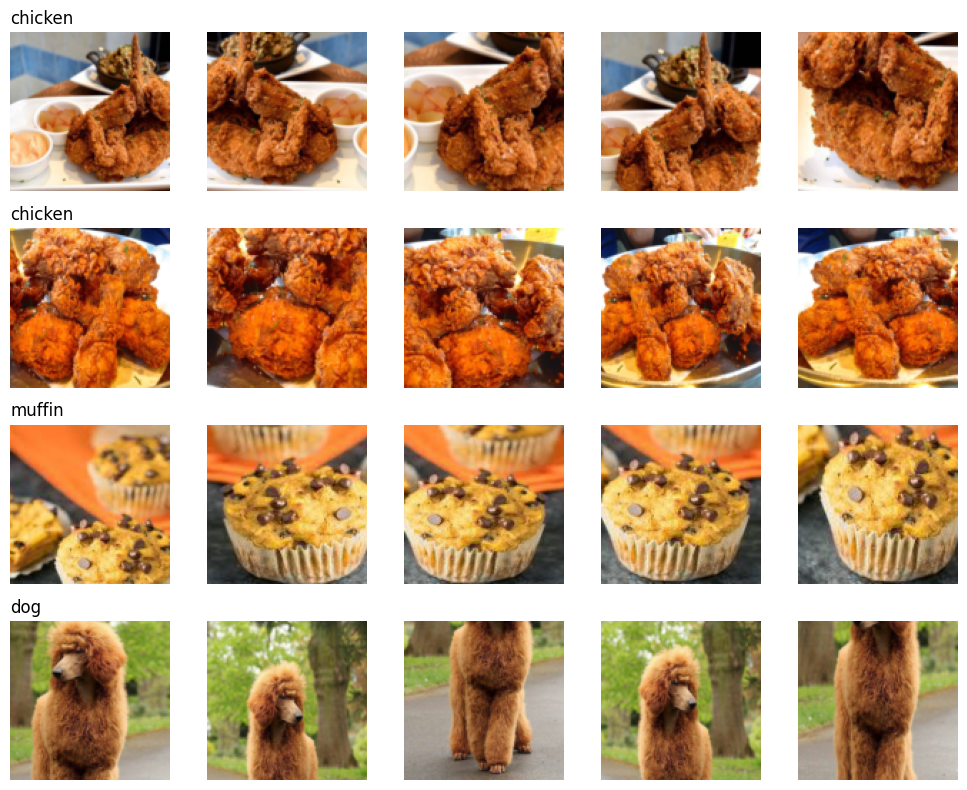

In [ ]:
#visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params
---------------------------------------------------------------
0 | model            | Sequential                | 113 K 
1 | accuracy         | MulticlassAccuracy        | 0     
2 | confusion_matrix | MulticlassConfusionMatrix | 0     
---------------------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.453     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


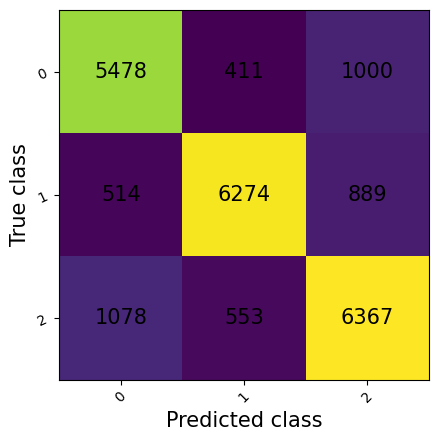

In [ ]:
wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
lit_model.confusion_matrix.plot()
wandb.finish()

In [ ]:
'''class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)
'''

In [ ]:
'''model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

# model = torchvision.models.mobilenet_v2(num_classes=num_classes)

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)

print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)'''

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


In [ ]:
'''# model = torch.compile(model)
lit_model = ImageClassifier(model)'''

In [ ]:
'''wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()'''

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 112 K 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.451     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
